# The Bias-Variance Tradeoff from Scratch

In [1]:
# General imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
%matplotlib inline

Bias-Variance Tradeoff is a balance in complexity observed in supervised learning models. In these models, we try to minimize errors working on a labeled training dataset, but our true efficiency lies in the generalization to unseen data. This leads to a situation where we do not want to be too good in fitting the training data; we want to fit something beyond it, an underlying pattern, shared by the training and the "for real" data.

Here we treat the tradeoff in the context of regression modeling, exposing a very detailed exploration of things behind it.

## 1. Motivation

We are selling icecream and we want to predict how much we sell in each hour of the day. So, one day, after each hour of work, we count the number of icecreams we sold; then we make a graphic like this:

Text(0.5,1,'Day 1')

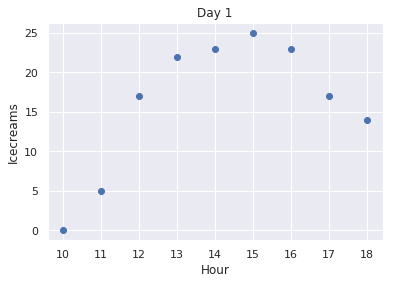

In [2]:
# Generate Day 1
rg = np.random.RandomState(26)
x = np.arange(10,19,1)
y_1 = (10-x)*(x-20) + 2*rg.randn(len(x))
y_1 = y_1.astype('int')

# Plot it
plt.scatter(x,y_1)
plt.xlabel('Hour')
plt.ylabel('Icecreams')
plt.title('Day 1')

That's nice, we see that the sales start slow and peak in the middle of the day. Now, since we know how to compute a linear regression, we use it to discover the functional dependence of our icecream sales on the time of the day. Let's do it!

Text(0.5,1,'Day 1')

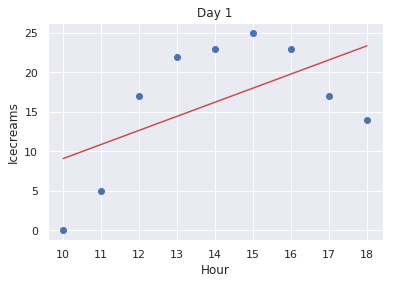

In [3]:
from sklearn.linear_model import LinearRegression

# Linear Regression
model = LinearRegression()
model.fit(x[:,np.newaxis],y_1)
y_lr = model.intercept_ + model.coef_*x # building manually the line

# Plot
plt.scatter(x,y_1)
plt.xlabel('Hour')
plt.ylabel('Icecreams')
plt.plot(x,y_lr, c='r')
plt.title('Day 1')

Wow! That turned out pretty terrible. Our model seems to be too simple for our icecream endeavour. That is no problem, we remember that we know a trick to transform a linear regression into a polynomial regression, and that will certainly be complex enough. We try again.

Text(0.5,1,'Day 1')

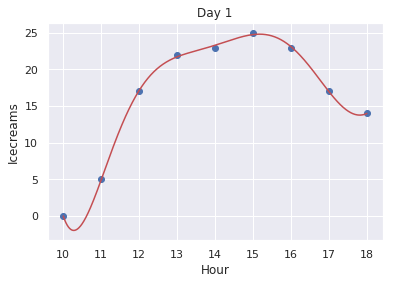

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 8-Polynomial regression
model = make_pipeline(PolynomialFeatures(8), LinearRegression())
model.fit(x[:,np.newaxis],y_1)
y_pr = model.predict(np.linspace(10,18,1000)[:,np.newaxis]) # not manually now =P

# Plot
plt.scatter(x,y_1)
plt.plot(np.linspace(10,18,1000),y_pr, c='r')
plt.xlabel('Hour')
plt.ylabel('Icecreams')
plt.title('Day 1')

Excellent! A perfect model. Now, we proceed to the next day, eager to test our powerful prediction:

Text(0.5,1,'Day 2')

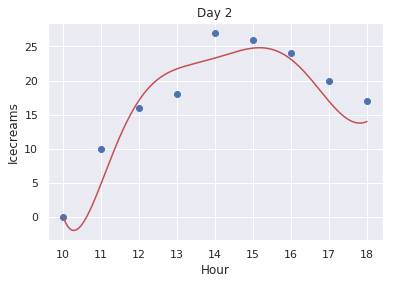

In [5]:
# Generate Day 2
rg = np.random.RandomState(37)
y_2 = -(x-10)*(x-20) + 2*rg.randn(len(x))
y_2 = y_2.astype('int')

# Plot
plt.scatter(x,y_2)
plt.plot(np.linspace(10,18,1000),y_pr, c='r')
plt.xlabel('Hour')
plt.ylabel('Icecreams')
plt.title('Day 2')

What? The model is not that good anymore! But wait! that's kind of obvious, because we would only have another perfect match if the two days were equal.

But then, why are the days not equal? Well, there must be more parameters other than the hour affecting our sales, so we cannot be so bound to predict it exactly using just the hour. Hmm... So the simple model was not able to capture the pattern on out data, and the complex model captured too much, becoming specific to Day 1 (see that day 1 represents training data and day 2 the test data in this case). It seems we are facing a trade-off for our model complexity.

## 2. Foundation

Let's change gears to really understand what is happening.

As the set of hours in the example above, we can have a set of data represented by the variable $X$. But in that case, $X$ had one dimension, the feature representing the hour. We could have any number of features; the hour $X[0]$, the temperature $X[1]$, the number of flavors available $X[2]$, etc. For each of these dimensions, our dataset has a value in each data point.

For each point in the dataset we also have a label, the quantity we want to know given all the considered features of a point. The set of labels, or target values, is represented by $Y$. Each observation consists of a pair $(X,Y)$.

We assume that the dataset mirrors an underlying structure, a function that is unavailable to us, $F(X)$, and that $Y$ are the observed values coming from $F(X)$. When we want to predict the label of a new data point in $X$, we want to project that point in this underlying function to obtain its label. We believe that every observation $(X,Y)$ comes from this mapping.

Given that the real structure behind the data is unavailable, our statistical model is an attempt to build an estimator of that function, $\hat{F}(X)$. We want the estimator to be as close as possible to the acual function $F(X)$.

Now, when constructing a dataset, we select which features to consider, and, given the abyssal complexity of reality, we (1) always leave out some feature and we (2) tend to take measurements with instrinsically shaking hands. Those are two sources of misinformation that we equally treat as noise; a simplification on which features $Y$ is conditioned to, and measurement errors. We can call this noise $\epsilon$ and see it as a catchall term for unintended variations on datapoints.

First of all, here is a visualization of how hidden features can be seen when ignored; take a look at this two dimensional function $fu(x_d,y_d)$ (representing an $F(X[0],X[1])$).

Text(0.5,0,'z_d')

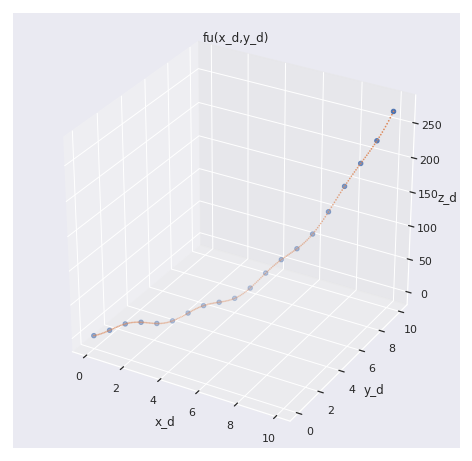

In [6]:
def fu(x_d,y_d):
    # A bizarre 3D function
    return (y_d**2/4+2)*x_d + 10*np.sin(np.pi*y_d/2)*np.sin(x_d)


from mpl_toolkits.mplot3d import Axes3D

# 3D plot - dots
x_d, y_d = np.linspace(0,10,20), np.linspace(0,10,20)
z_d = fu(x_d,y_d)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(x_d,y_d,z_d)

# 3D plot - line
xa, ya = np.linspace(0,10,200), np.linspace(0,10,200)
za = fu(xa,ya)
ax.scatter(xa,ya,za, s=0.5)

ax.set_title('fu(x_d,y_d)')
ax.set_xlabel('x_d')
ax.set_ylabel('y_d')
ax.set_zlabel('z_d')

Note that it is a nonlinear function of $(x_d,y_d)$. Now, let's make a dataset selecting only $x_d$ as a parameter while being oblivious of the $y_d$ value (we take some points with $y_d=0$, some with $y_d=2$, etc., but suppose we don't know that). We also make plots of $fu(x_d,y_d)$ for when $y_d$ is kept constant with values 4 (green) and 3 (red). See that the red curve is even linear in $x_d$.

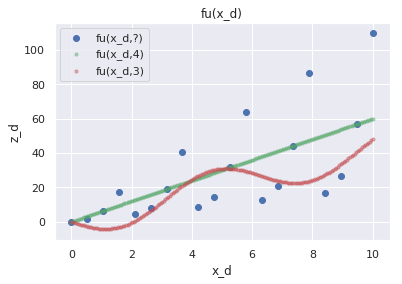

In [7]:
# Making functions from various y values
zi = [fu(x_d,i) for i in range(0,8,2)]

# Plot some points from each, somewhat shuffled
partials = [zi[0][0::4],zi[1][1::4],zi[2][2::4],zi[3][3::4]]
vector_list = [[vec[i] for vec in partials] for i in range(5)]
z_d2 = np.hstack(vector_list)
fig, ax = plt.subplots(1,1)
ax.scatter(x_d,z_d2)

# Line with y=4
z2a = fu(xa,4)
ax.scatter(xa,z2a, s=10, alpha=0.4, c='g')

# Line with y=3
z3a = fu(xa,3)
ax.scatter(xa,z3a, s=10, alpha=0.4, c='r')

ax.set_xlabel('x_d')
ax.set_ylabel('z_d')
ax.set_title('fu(x_d)')
ax.legend(['fu(x_d,?)','fu(x_d,4)','fu(x_d,3)'])

So, ignoring an important parameter can disrupt the true patterns of the data. But, usually, we are always ignoring numerous little things that add up just as fluctuations around consistent patterns or are constant through the whole process we are concerned with. Yes, we are ignoring some quantum effects and who is the seller in our icecream model, but they are either (very) little noise or just always the same in our dataset. Now, we go back to labeled datasets $(X,Y)$, and hidden functions $F(X)$.

Given all this, we can build a relation between $X$ and its labels:

$$ Y = F(X) + \epsilon $$

That is read as follows: given the values of all features ($X$), the label we observe ($Y$) is the projection of $X$ on the hidden function $F(X)$ plus the noise that moves data away from the clean $F$. The noise term, $\epsilon$, is assumed to have zero mean, because if it has a non-zero mean, that's a pattern, and we can just shift it to $F$.

In order to make an estimator $\hat{F}$, we assume that $F$ exists. What we can't know is whether $F$'s form has a first-principles explanation, since, for example, we may be leaving out important features of its true form in nature. But our functional form can be ultimately wrong; our estimator doesn't even have to be a closed functional form, we just want to harvest labels here. So we are good.

When models are fitting an estimator to the training data, they are holding an error function they are to minimize. Finding the best fit of the estimator is finding its form in a way that makes the error minimal.

Let's see then what our two models above are doing. The linear regressor assumes a linear functional form for the estimator:

$$ \hat{F}(X) = AX+B $$

Then, fitting the model to the data is finding the best coefficients $A$ and $B$ to minimize the error function $\sum_i(Y_i-\hat{F}(X_i))^2$ (the error function here is the sum of squared differences between each label and our estimation of it for each training point, literally the squared sum of our errors). This model does what it can. Now, the polynomial regression that we chose, with a degree of 8, has as its estimator a polynomial of degree 8:

$$ \hat{F}(X) = A_1X^8+A_2X^7+A_3X^6+A_4X^5+A_5X^4+A_6X^3+A_7X^2+A_8X+A_0 $$

It has 9 parameters to be calculated by minimizing the error. See that the linear model is the polynomial model with degree equal to 1. Something interesting to notice is that we have 9 data points, and a polynomial with 9 degrees of freedom can perfectly fit to 9 points, in the same way as we can always make a line that passes through 2 points (the linear fit has 2 parameters). But we shall see that our goal is not to perfectly fit the points, it is to capture patterns, hidden structures in data. In the specific case of our icecream toyset above, $F$ is not hidden from us; it is the function $F(X) = (10-x)(x-20)$, and this is exactly what we are trying to capture with our estimators (they don't know our $F$).

Each data point in our hands acts as a blurred peek into the hidden realm of $F$, and our task is to paint the estimator using these visions we had and our cool techniques. The linear regression above is like the painting of a child that underfits their visions by not even knowing how to be accurate, and the polynomial regression above is like the painting of a master that overfits their visions by perfectly painting the blurs. What we want is a painting that beautifully captures just the landscape.

We say that the linear, underfitted, model above has high bias and low variance; it is uncapable of representing that kind of data, but we do not expect it to be better or worse in day 2. And we say that the polynomial, overfitted, model above has low bias and high variance; it seems a perfect fit for day 1, but it is much worse in day 2.

So it seems that, if you get a high bias, making a poor estimator, it is not hard to achieve consistency and having a low variance. But if you try to zero the bias on day 1, the model will read the noise as part of $F$. In day 2, $F$ is the same, but the noise is not, and it will feed the variance of your estimator. High bias or high variance increase the error in our estimation. We wish we could zero both, but, as seen, that is impossible. We have to choose a middle-ground in complexity.

Ok. That is the trade-off. But what exactly is variance in this context? And bias?

# 3. Variance

Variance is a property of the estimator $\hat{F}$. It measures how much the estimator would have to change when fitting different sets of training data of the same source.

The estimator in our model might have a functional form or parameters, but in every case it is an abstract structure that is manifested in a real form when fitted to the data. In the case of the linear regressor, it has the abstract form of a linear function, with general parameters $A$ and $B$, that is instantiated into a specific line with calculated values for $A$ and $B$.

So, if we take our estimator and fit it multiple times with different training data (for example, apply our linear regression to day 1, then day 2, etc.), we will have multiple instances of the estimator; one for each fit. The variance is how much, on average, the different fits differ from each other.

When we say we want low variance for our model, it means that we want to produce consistency in our estimator. The underlying function we want to estimate, $F$, is the same for every set of training data, so we need $\hat{F}$ to be roughly the same too. If the estimator has to change to fit a new set of data, how can we generalize it? That is what happens to our polynomial model above, it is so obsessed with day 1 that it builds a pattern that is hard to be reproduced by the other days; every fit should be a very different wild polynomial. The linear model, on the other hand, is so simple that, regardless of the day, the fit will always be a line like that one, almost at the same place. Let's visualize this:

Text(0.5,1,'Polynomial Fit - Day 2')

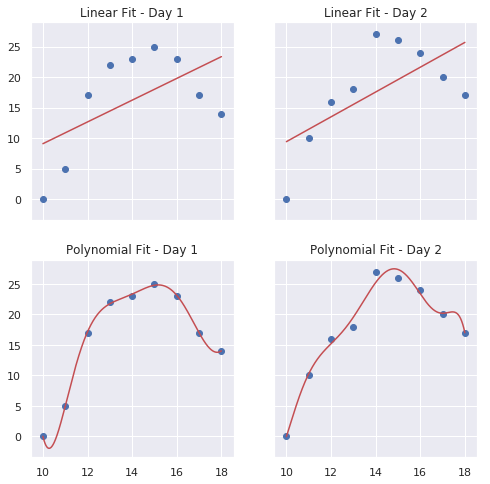

In [8]:
fig, ax = plt.subplots(2,2, figsize=(8,8), sharex=True,sharey=True)

# Plot of degree=1, Day 1
ax[0,0].scatter(x,y_1)
ax[0,0].set_title('Linear Fit - Day 1')
ax[0,0].plot(x,y_lr, c='r')

# Fit and plot of degree=1, Day 2
model = LinearRegression()
model.fit(x[:,np.newaxis],y_2)
y_lr2 = model.intercept_ + model.coef_*x
ax[0,1].scatter(x,y_2)
ax[0,1].plot(x,y_lr2, c='r')
ax[0,1].set_title('Linear Fit - Day 2')

# Plot of degree=8, Day 1
ax[1,0].scatter(x,y_1)
ax[1,0].plot(np.linspace(10,18,1000),y_pr, c='r')
ax[1,0].set_title('Polynomial Fit - Day 1')

# Fit and plot of degree=8, Day 2
model = make_pipeline(PolynomialFeatures(8), LinearRegression())
model.fit(x[:,np.newaxis],y_2)
y_pr2 = model.predict(np.linspace(10,18,1000)[:,np.newaxis])
ax[1,1].scatter(x,y_2)
ax[1,1].plot(np.linspace(10,18,1000),y_pr2, c='r')
ax[1,1].set_title('Polynomial Fit - Day 2')

Note how the linear estimators are almost the same (low variance) and the polynomial ones have different shapes (high variance).

Mathematically, we express the variance as 
$$Var_T(\hat{F}) = E_T\big[\big(\hat{F}-E_T[\hat{F}]\big)^2\big],$$

where the average $E_T$ is taken over many fits, so the variance is dependant on a set T of training datasets (for example, the set T: (Day1, Day2, Day3, Day 4) for training).

So, over the many fits over T, you can have an average estimator $\hat{F}_T=E_T[\hat{F}]$; we can view it as a more privileged estimator, because it takes information from all data points in T and is built over many instances of fit. Now, the variance over T is the average (squared) difference between each estimator $\hat{F}_{T[0]}$, $\hat{F}_{T[1]}$, $\hat{F}_{T[2]}$, etc., and the average estimator $\hat{F}_T$. See how it captures all the fluctuations in the estimator for different fits?

Is the variance a single number for the estimator? Well, it depends. It is defined for each datapoint, so you can know the variance of $\hat{F}(X)$ on any particular point on the domain of the data (just evaluate $\hat{F}(X)$ on a specific point of $X$ on the expression above). The variance that is a single number associated with the estimator, that is its overall variance, is the (weighted) sum of local variances over the entire data space or over a set of test data, depending on the context.

# 4. Bias

Now, bias. It is also a property of the estimator $\hat{F}$. It is a measure of how capable it is to capture patterns in the data.

Take those different instances of our estimators, created by fitting it in multiple training sets; they may be different from each other, remember the variance, but if on average they get close to the real $F$, our estimator is heading to a good direction (what the average is doing is juts canceling the noise and preserving the shared patterns of the many fits). It means that if we keep averaging fits from more training datasets, we can eventually reach a very precise fit of the whole $F$. It means low bias.

An averaged, low biased, estimator has the capacity to grow close to $F$. When the estimator has a high bias, it doesn't have that capacity to improve with additional fits. That is a way to see how a too simple estimator is inherently unable to capture the patterns of the data; not even infinite data can save it.

We can see this in the variance visualization above. Because the linear model always gets lines, no matter how many days we add up to fit, it will ever be a poor line. Now, the polynomial model, always keeping track of nuances on data, will eventually capture all that is good while cancelling out the specific noises of each day.

Mathematically, we express the bias as

$$ Bias_T = E_T[\hat{F}] - F .$$

Here we see the same privileged estimator from before, $\hat{F}_T=E_T[\hat{F}]$. Remebmer that it means an estimator generalized over the set of training sets $T$. So the bias is simply the difference between this generalized estimator and the function we want to estimate; see that zero bias means that, on that average, we hit $F$ exactly. The same discussion of variance applies to the output of the bias. The estimator has a value of bias for each point in the data space, an overall bias that is their sum, or a bias associated with a set of test data.

In practice, these two measures, bias and variance, depend on the set T of training sets. But theoretically, where we can fantasize about having infinite training sets, we can approach a more intrinsic definition of these measures. So like that we can talk about a bias or a variance of an estimator without being conditioned on a particular set of fits.

# 5. The Tradeoff

Let's derive the tradeoff mathematically. Take that same set of training sets, T. We are going to evaluate the estimator on T, and our measures of error, bias and variance are conditioned on T. So, what we have is a bunch of instances of the estimator $\hat{F}$ fitted in each training set in T.

Now, we are trying to predict a new data point and we ask ourselves: what is the expected error of our estimator, based on what we have? If we take one instance and predict the new data, we have a measure of error. We can then average it over all instances, taking the mean conditioned on T, $E_T$. What measure of error to use? The squared residual is the best in this case, it is a standard measure of how much wrong the estimator is, because residuals are how far the estimator is from the label. Here, we need the residuals to be absolute values, sure, but why squared? Squaring instead of just taking the absolute value doesn't alter the meaning we are trying to convey (a magnitude of the mistake); the thing is that it is in the most adequate form to show the tradeoff, based on how bias and variance are defined. So we have:

$$ Expected Error = E_T[(Y-\hat{F})^2]. $$

What we need to do is tweak the expression to put it in function of the bias and the variance. So, we get rid of $Y$ and fetch some $E_T[\hat{F}]$. Remember that $Y = F + \epsilon$:

$$ E_T[(Y-\hat{F})^2] = E_T[(F+\epsilon-\hat{F}+E_T[\hat{F}]-E_T[\hat{F}])^2] = E_T[(bias + v + \epsilon)^2].$$

Here, we called $v = (E_T[\hat{F}]-\hat{F})$; it is the building block of the variance, $var = E_T[v^2]$. Unravelling the square, we have

$$ E_T[(Y-\hat{F})^2] = E_T[bias^2 + v^2 + \epsilon^2 + 2\epsilon.v + 2\epsilon.bias + 2bias.v]. $$

Recall that we have some assumptions on $\epsilon$. It is supposed to have a zero mean and, as a noise, to be independent of our estimator, so they are not correlated. So all terms with $\epsilon^1$ vanish under the mean. The last term also vanishes, see that the bias is unchanged by the mean and that $v$ cancels out under it. We end up with the first three terms:

$$ E_T[(Y-\hat{F})^2] = E_T[bias^2] + E_T[v^2] + E_T[\epsilon^2] $$

There we have it:

$$ E_T[(Y-\hat{F})^2] = bias^2 + var + \sigma^2 $$

and $\sigma^2$ is how we are calling the variance of the noise. See how both bias and variance are the factors of our error together with the intrinsic noise of the data (which we can do nothing about, so it is a lower threshold of our error). Here we can explicitly see that when wanting to minimize the prediction error, we are wanting to minimize the sum of squared bias and variance. Then, one can't make up for the other; we have to take care of their sum.

If we have an entire test set or if we want to evaluate the entire data space, our error is going to be the sum of every individual errors, and so will be with bias and variance. Adding each (local) point contribution forms the "global" unique bias (or squared bias as you can see) and variance of the estimator. So the equation above holds for all these contexts.

Now, we visualize and act on the tradeoff from our example. We are going to take a set T of days, take polynomials from degrees 1 to 8, calculate their overall bias and variance over our data space of hours (10 to 18), see their relation and finally pick the best model, the best degree.

But how can we calculate the bias if it depends on $F$? Well, based on how $Y$ depends on $F$, we have $E_T[Y]=F(X)+E_T[\epsilon]=F(X)$. So we can calculate it through Y? Yeah, it makes sense, because the noise has to cancel out over many measures of labels of the same data point. But this is something that exposes very well the imperfect conditionallity on T carried by these averages. These are things that are guaranteed to "converge", but we have to feed them properly. If we take few fits, and/or not cover well the domain of data points, we can't expect our $E_T[\epsilon]$ to nicely be zero.

Let's code this; first, creating T and visualizing of some days (we are taking 20 days for T):

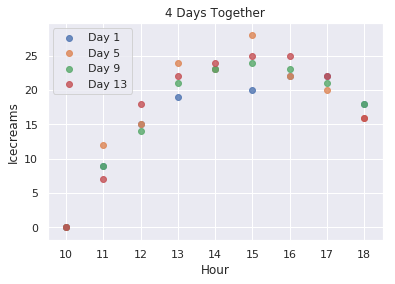

In [9]:
# Creating the set of days, T, and setting sells from opening hour to 0
T = np.array([((10-x)*(x-20) + 2*rg.randn(len(x))).astype('int') for i in range(20)])
T[:,0] = 0

# Plot of 4 days
for i in range(1,14,4):
    plt.scatter(x,T[i], alpha=0.8)
plt.xlabel('Hour')
plt.ylabel('Icecreams')
plt.title('4 Days Together')
plt.legend(['Day 1','Day 5','Day 9','Day 13'])


Now, we see how our version of the calculated $F$ turns out:

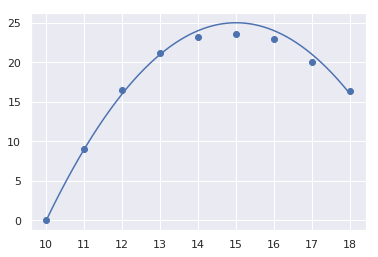

In [10]:
# Calculating and plotting F = average of Y
F = T.sum(axis=0)/20
plt.scatter(x,F)

# Function used to generate the points
x_space = np.linspace(10,18,1000)
plt.plot(x_space,(10-x_space)*(x_space-20))

Why isn't it closer? Actually, it is something I realized just now: Our $F$ is not exactly $(10-X)(X-20)$. We are forcing the count to be an integer, so it changes the function to something else. Note how the dots are a little under the function, expressing the fact that .astype('int') always rounds down the number to a smaller integer; that's interesting. The dots must be closer to the real $F$ than the plotted function. So now we know that the best estimator is going to be one that "overfits" the points above, i.e. the one that is closest to $F$.

We now prepare our models:

In [11]:
# Making the models
model = [make_pipeline(PolynomialFeatures(i), LinearRegression()) for i in range(1,9)]

# Setting variables. var_ is supposed to be the local var, needed in retrospect for the local plots
bias2, var, var_, EF_ = list(range(len(model))), list(range(len(model))), list(range(len(model))), list(range(len(model)))
F_ = [list(range(len(T))) for i in range(len(model))] # F_ij is going to be the estimator for model i in day j

Then we calculate the squared bias and the variance for the 8 models over the sample of 20 days.

In [12]:
# Calculating the overall squared bias and the variance for each model 
for i in range(len(model)):
    for j in range(len(T)):
        F_[i][j] = model[i].fit(x[:,np.newaxis],T[j]).predict(x[:,np.newaxis])
    EF_[i] = sum(F_[i])/20 # average of the estimator
    bias2[i] = ((F-EF_[i])**2).sum()
    for j in range(len(T)):
        var_[i] += (EF_[i]-F_[i][j])**2 # here, var_ was used so we could take this value afterwards
    var[i] = var_[i].sum()/20
    
bias2 = np.array(bias2)
var = np.array(var)

Finally, we plot the tradeoff and see what is the best degree for our polynomial regression:

The best degree is 2


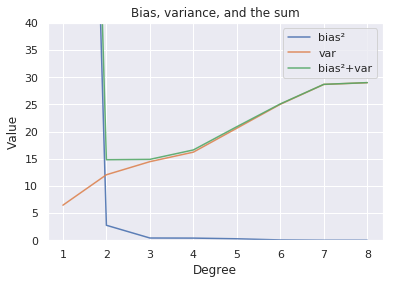

In [13]:
# Plotting the tradeoff
plt.plot(np.arange(8)+1,bias2, alpha=0.9)
plt.plot(np.arange(8)+1,var, alpha=0.9)
plt.plot(np.arange(8)+1,var+bias2, alpha=0.9)

plt.ylim([0,40])
plt.xlabel('Degree')
plt.ylabel('Value')
plt.title('Bias, variance, and the sum')
plt.legend(['bias²','var','bias²+var'])
print('The best degree is ' + str(np.argmin(var+bias2)+1))

As we could expect, the best degree is 2 (note that the degree 1 has so much bias that we had to cut it). Now, see that the point of degree two is an inversion point for the sum of (squared) bias and variance. The bias is readily shut after degree 1, but then the variance dominates. Following the tradeoff, the optimal place is degree 2.

Hey, so let's plot the best model over day 1:

Predictions: [-1.34545455  8.26363636 15.63679654 20.77402597 23.67532468 24.34069264
 22.77012987 18.96363636 12.92121212]


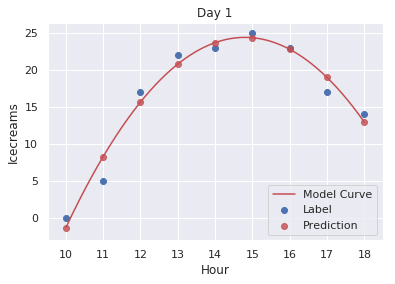

In [14]:
# Fitting the best model, degree=2
best_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
best_model.fit(x[:,np.newaxis],y_1)
y_bc = best_model.predict(np.linspace(10,18,1000)[:,np.newaxis])
y_b = best_model.predict(x[:,np.newaxis])

# Plot
plt.scatter(x,y_1)
plt.scatter(x,y_b,c='r',alpha=0.8)
plt.plot(np.linspace(10,18,1000),y_bc, c='r')
plt.xlabel('Hour')
plt.ylabel('Icecreams')
plt.title('Day 1')
plt.legend(['Model Curve','Label','Prediction'])

print('Predictions: {0}'.format(y_b)) # prediction values for day 1

That is great! Note that the predictions are not integers, so the model does not maintain that (we were expecting so). Let's perform a simple GridSearch on the degree using day 1, to check the best model:

In [15]:
# GridSearch to check the best degree
from sklearn.model_selection import GridSearchCV
degrees = np.arange(1,9)
model = make_pipeline(PolynomialFeatures(), LinearRegression())
GS = GridSearchCV(model, {'polynomialfeatures__degree':degrees}).fit(x[:,np.newaxis],y_1)

print('The best parameter: {0}'.format(GS.best_params_['polynomialfeatures__degree']))

The best parameter: 2


So, we are being consistent here. Now, it will be cool to visualize the distribution of the local bias and variance of each data point (each hour), for some degrees:

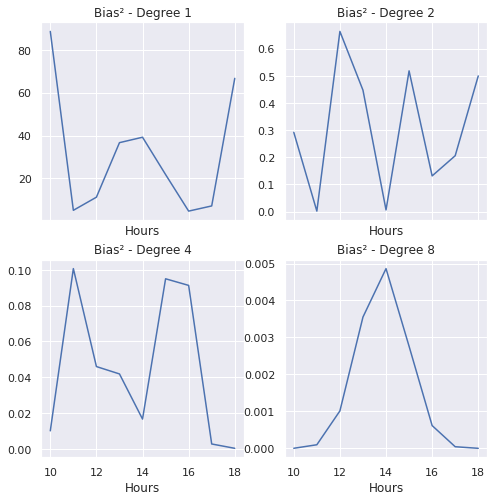

In [16]:
# Local bias plots
fig, ax = plt.subplots(2,2,figsize=(8,8), sharex=True)

def plot_ax(ax,model,title):
    # Plot in ax the bias for model i
    ax.plot(x,((F-EF_[model])**2))
    ax.set_xlabel('Hours')
    ax.set_title(title)

plot_ax(ax[0,0],0,'Bias² - Degree 1')
plot_ax(ax[0,1],1,'Bias² - Degree 2')
plot_ax(ax[1,0],3,'Bias² - Degree 4')
plot_ax(ax[1,1],7,'Bias² - Degree 8')

The bias from degree 1 (the linear regression) is way higher than the rest, see the scale. The hours in which the bias is higher represent points where the estimator was less able to capture the pattern. See how the linear estimator has a hard time with the turning point in the middle and the extremes; we can agree with that by checking the linear plots.

Now, the variance:

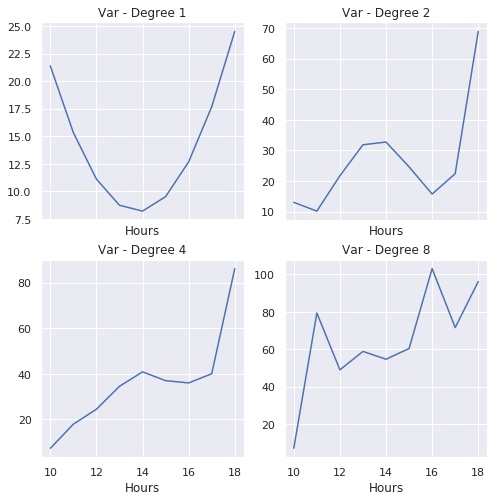

In [17]:
# Local variance plots
fig, ax = plt.subplots(2,2,figsize=(8,8), sharex=True)

def plot_ax(ax,model,title):
    # Plot in ax the variance for model i
    ax.plot(x,var_[model])
    ax.set_xlabel('Hours')
    ax.set_title(title)

plot_ax(ax[0,0],0,'Var - Degree 1')
plot_ax(ax[0,1],1,'Var - Degree 2')
plot_ax(ax[1,0],3,'Var - Degree 4')
plot_ax(ax[1,1],7,'Var - Degree 8')

The points with higher variance are the ones where the models had to change the most between different fits. The linear estimator is poor in the extremes (but see that now it is the one with the lowest scale); we can interpret this curve by reasoning that the differences in the lines are mainly their slopes in this case, and these little twists cause more variation at the extremes than at the middle of the line.

Finally, let's build an ensemble from polynomial regressions of degree 8. This is the model with the most variance, but it has the least bias. The reasoning is that, if we average many of these models on T, we get a good one guaranteed by the low bias.

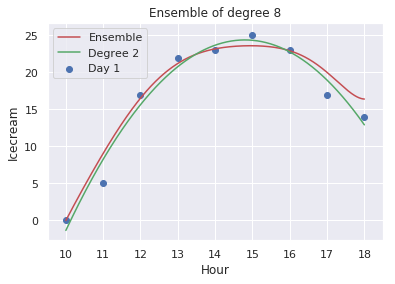

In [18]:
# Initiating the ensemble of 8-polynomials
model = make_pipeline(PolynomialFeatures(8), LinearRegression())
ens = model.fit(x[:,None],T[0]).predict(np.linspace(10,18,1000)[:,None])

# Averaging over all models to make the ensemble
for i in range(1,20):
    model = make_pipeline(PolynomialFeatures(8), LinearRegression())
    ens += model.fit(x[:,None],T[i]).predict(np.linspace(10,18,1000)[:,None]) # None is the same as creating an axis here
ens = ens/len(T)

# Plot of the ensemble, the best model and day 1
plt.plot(np.linspace(10,18,1000),ens, c='r')
plt.scatter(x,y_1)
plt.plot(np.linspace(10,18,1000),y_bc, c='g')

plt.xlabel('Hour')
plt.ylabel('Icecream')
plt.title('Ensemble of degree 8')
plt.legend(['Ensemble','Degree 2','Day 1'])

Well, this one turned out pretty nice too; how close the ensemble is to $F$ is conditioned on how much fitting on T is sufficient to cancel all the noise grabbed by the individual fits.

# 6. Conclusion

I hope to have given (right) explanations for every issue behind our wandering to the bias-variance tradeoff. I set out to do this partially because of my own confusion in trying to deeply understand these concepts from studying numerous texts, videos and books I found. Those are the conclusions I got from repeatedly thinking over it. For me, the best source on the subject that I came across so far is the book from C. M. Bishop, [Pattern Recognition and Machine Learning](https://www.goodreads.com/book/show/55881.Pattern_Recognition_and_Machine_Learning), but it has a Bayesian approach. I suggest that you go an try to generalize/adapt our discussion of the tradeoff to the bayesian framework and to classification problems.